# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  At

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics.

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : ['median', 'mean', 'quantile']
            The operation to perform. This uses the equivalent pandas function. Note
            that quantile means the value of the data at a given point in the cumulative
            distribution of values at each point in the timeseries, for each timeseries
            once the groupby is applied. As a result, using ``q=0.5`` is is the same as
            taking the median and not the same as taking the mean/average.

        na_override: [int, float]
            Convert any nan value in the timeseries meta to this value during processsing.
            The meta values converted back to nan's before the dataframe is returned. This
            should not need to be changed unless the existing metadata cla

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

time                                                          2000-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature                    0.0   
       W/m^2 example ssp119   Radiative Forcing                      0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2         0.0   

time                                                          2001-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.486364   
       W/m^2 example ssp119   Radiative Forcing                 0.506294   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.481175   

time                                                          2002-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.847722   
       W/m^2 example ssp119   Radiative Forcing                 0.715472   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.792709   

time                                                          2003-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.861271   
       W/m^2 example ssp119   Radiative Forcing                 1.601016   
       ppm   example ssp119   Atmospheric Concentrations|CO2    1.246468   

time                                                          2004-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               2.103715   
       W/m^2 example ssp119   Radiative Forcing                 1.978405   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.299480   

time                                                          2005-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.648397   
       W/m^2 example ssp119   Radiative Forcing                 2.320115   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.656452   

time                                                          2006-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               2.837285   
       W/m^2 example ssp119   Radiative Forcing                 2.940294   
       ppm   example ssp119   Atmospheric Concentrations|CO2    3.455382   

time                                                          2007-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               2.610184   
       W/m^2 example ssp119   Radiative Forcing                 2.828243   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.509127   

time                                                          2008-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               4.731882   
       W/m^2 example ssp119   Radiative Forcing                 4.083214   
       ppm   example ssp119   Atmospheric Concentrations|CO2    4.276478   

time                                                          2009-01-01  ...  \
region unit  model   scenario variable                                    ...   
World  K     example ssp119   Surface Temperature               6.003355  ...   
       W/m^2 example ssp119   Radiative Forcing                 5.317940  ...   
       ppm   example ssp119   Atmospheric Concentrations|CO2    3.842685  ...   

time                                                          2091-01-01  \
region unit  model   scenario variable                                     
World  K     

### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

time                                                          2000-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature                    0.0   
       W/m^2 example ssp119   Radiative Forcing                      0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2         0.0   

time                                                          2001-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.448853   
       W/m^2 example ssp119   Radiative Forcing                 0.559057   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.496950   

time                                                          2002-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.970299   
       W/m^2 example ssp119   Radiative Forcing                 0.642713   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.674295   

time                                                          2003-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.937236   
       W/m^2 example ssp119   Radiative Forcing                 1.919998   
       ppm   example ssp119   Atmospheric Concentrations|CO2    1.198431   

time                                                          2004-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               2.140634   
       W/m^2 example ssp119   Radiative Forcing                 1.953049   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.301543   

time                                                          2005-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.510924   
       W/m^2 example ssp119   Radiative Forcing                 2.284650   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.761817   

time                                                          2006-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               3.246538   
       W/m^2 example ssp119   Radiative Forcing                 2.642070   
       ppm   example ssp119   Atmospheric Concentrations|CO2    3.831572   

time                                                          2007-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.790422   
       W/m^2 example ssp119   Radiative Forcing                 2.246602   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.368653   

time                                                          2008-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               5.689367   
       W/m^2 example ssp119   Radiative Forcing                 3.838470   
       ppm   example ssp119   Atmospheric Concentrations|CO2    3.908021   

time                                                          2009-01-01  ...  \
region unit  model   scenario variable                                    ...   
World  K     example ssp119   Surface Temperature               5.450291  ...   
       W/m^2 example ssp119   Radiative Forcing                 5.596963  ...   
       ppm   example ssp119   Atmospheric Concentrations|CO2    3.238402  ...   

time                                                          2091-01-01  \
region unit  model   scenario variable                                     
World  K     

### Other quantiles

In [8]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

time                                                          2000-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature                    0.0   
       W/m^2 example ssp119   Radiative Forcing                      0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2         0.0   

time                                                          2001-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.306071   
       W/m^2 example ssp119   Radiative Forcing                 0.192435   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.136897   

time                                                          2002-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.077813   
       W/m^2 example ssp119   Radiative Forcing                 0.186037   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.183599   

time                                                          2003-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.883962   
       W/m^2 example ssp119   Radiative Forcing                 0.471778   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.337592   

time                                                          2004-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.651953   
       W/m^2 example ssp119   Radiative Forcing                 1.142054   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.984807   

time                                                          2005-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.425576   
       W/m^2 example ssp119   Radiative Forcing                 1.519154   
       ppm   example ssp119   Atmospheric Concentrations|CO2    1.440322   

time                                                          2006-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               1.406838   
       W/m^2 example ssp119   Radiative Forcing                 1.601721   
       ppm   example ssp119   Atmospheric Concentrations|CO2    1.944008   

time                                                          2007-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               0.781976   
       W/m^2 example ssp119   Radiative Forcing                 0.747999   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.604793   

time                                                          2008-01-01  \
region unit  model   scenario variable                                     
World  K     example ssp119   Surface Temperature               2.401297   
       W/m^2 example ssp119   Radiative Forcing                 1.880562   
       ppm   example ssp119   Atmospheric Concentrations|CO2    2.074795   

time                                                          2009-01-01  ...  \
region unit  model   scenario variable                                    ...   
World  K     example ssp119   Surface Temperature               3.539931  ...   
       W/m^2 example ssp119   Radiative Forcing                 2.713741  ...   
       ppm   example ssp119   Atmospheric Concentrations|CO2    0.516323  ...   

time                                                          2091-01-01  \
region unit  model   scenario variable                                     
World  K     

## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [9]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :obj:`pd.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The operatio

In [10]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.83, 0.95, "mean", "median"]
)
summary_stats

time                                                                   2000-01-01  \
region unit  model   scenario variable                       quantile               
World  K     example ssp119   Surface Temperature            0.05             0.0   
       W/m^2 example ssp119   Radiative Forcing              0.05             0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.05             0.0   
       K     example ssp119   Surface Temperature            0.17             0.0   
       W/m^2 example ssp119   Radiative Forcing              0.17             0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.17             0.0   
       K     example ssp119   Surface Temperature            0.83             0.0   
       W/m^2 example ssp119   Radiative Forcing              0.83             0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.83             0.0   
       K     example ssp119   Surface Temperature            0.95             0.0   
       W/m^2 example ssp119   Radiative Forcing              0.95             0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.95             0.0   
       K     example ssp119   Surface Temperature            mean             0.0   
       W/m^2 example ssp119   Radiative Forcing              mean             0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 mean             0.0   
       K     example ssp119   Surface Temperature            median           0.0   
       W/m^2 example ssp119   Radiative Forcing              median           0.0   
       ppm   example ssp119   Atmospheric Concentrations|CO2 median           0.0   

time                                                                   2001-01-01  \
region unit  model   scenario variable                       quantile               
World  K     example ssp119   Surface Temperature            0.05        0.110090   
       W/m^2 example ssp119   Radiative Forcing              0.05        0.068298   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.05        0.107098   
       K     example ssp119   Surface Temperature            0.17        0.306071   
       W/m^2 example ssp119   Radiative Forcing              0.17        0.192435   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.17        0.136897   
       K     example ssp119   Surface Temperature            0.83        0.785446   
       W/m^2 example ssp119   Radiative Forcing              0.83        0.818674   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.83        0.758038   
       K     example ssp119   Surface Temperature            0.95        0.807093   
       W/m^2 example ssp119   Radiative Forcing              0.95        0.899657   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.95        0.867473   
       K     example ssp119   Surface Temperature            mean        0.486364   
       W/m^2 example ssp119   Radiative Forcing              mean        0.506294   
       ppm   example ssp119   Atmospheric Concentrations|CO2 mean        0.481175   
       K     example ssp119   Surface Temperature            median      0.448853   
       W/m^2 example ssp119   Radiative Forcing              median      0.559057   
       ppm   example ssp119   Atmospheric Concentrations|CO2 median      0.496950   

time                                                                   2002-01-01  \
region unit  model   scenario variable                       quantile               
World  K     example ssp119   Surface Temperature            0.05        0.015013   
       W/m^2 example ssp119   Radiative Forcing              0.05        0.169865   
       ppm   example ssp119   Atmospheric Concentrations|CO2 0.05        0.087292   
       K     example ssp119   Surface Temperature            0.17        0.077813   
       W/m^2 example ssp119   Radiative Forcing              0.17        0.186037   
   

### Plotting

We can then cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [11]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<scmdata.ScmRun (timeseries: 18, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119      K             Surface Temperature
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	3   example     0.17  World   ssp119      K             Surface Temperature
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	6   example     0.83  World   ssp119      K             Surface Temperature
	7   example     0.83  World   ssp119  W/m^2               Radiative Forcing
	8   example     0.83  World   ssp119    ppm  Atmospheric Concentrations|CO2
	9   example     0.95  World   ssp119      K             Surface Temperature
	10  example     0.95  World   ssp11

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

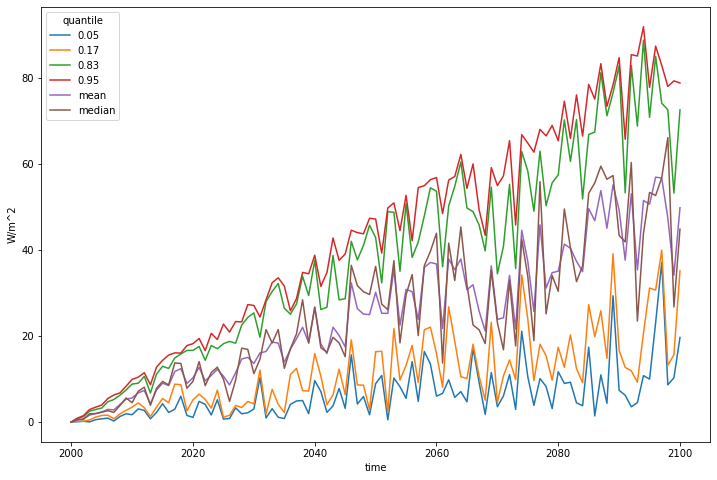

In [12]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)

> /Users/znicholls/Documents/AGCEC/MCastle/scmdata/src/scmdata/plotting.py(182)plumeplot()
    180                     import pdb
    181                     pdb.set_trace()
--> 182                     p = ax.fill_between(
    183                         xaxis,
    184                         hsdf.filter(quantile=q[0]).values.squeeze(),

ipdb> hsdf.filter(quantile=q[0])
*** TypeError: Cannot cast CategoricalIndex to dtype float64
ipdb> p q
(0.05, 0.95)
ipdb> hsdf
<scmdata.ScmRun (timeseries: 6, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario unit             variable
	0   example     0.05  World   ssp119    K  Surface Temperature
	3   example     0.17  World   ssp119    K  Surface Temperature
	6   example     0.83  World   ssp119    K  Surface Temperature
	9   example     0.95  World   ssp119    K  Surface Temperature
	12  example     mean  World   ssp119    K  Surface Temperature
	15  example   median  World   s

ipdb> hsdf.filter(quantile="mean")
*** TypeError: expected string or bytes-like object
ipdb> q


BdbQuit: 

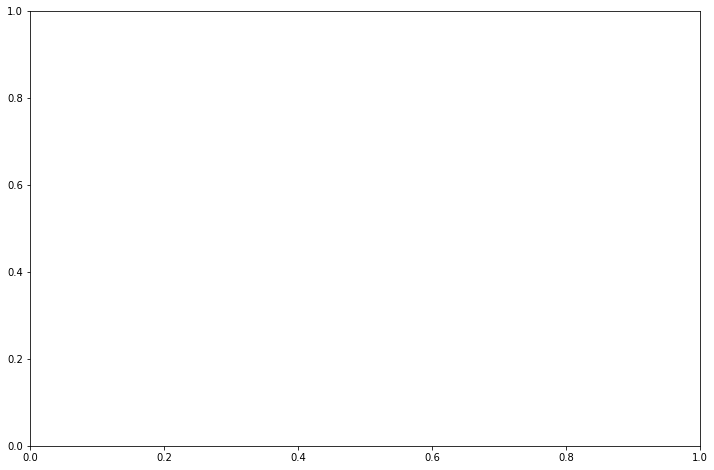

In [13]:
summary_stats_scmrun.filter(variable="Surface Temperature").plumeplot(time_axis="year")

In [ ]:
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[((0.05, 0.95), 0.2), ((0.17, 0.83), 0.5), ((0.5,), 1.0),],
)